<a href="https://colab.research.google.com/github/Har02sh/fashion-mnist-mlp-pytorch/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torchvision import datasets, transforms

In [4]:
# SETTING DEVICE VARIABLES
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if device == "cuda":
  torch.cuda.manual_seed(42)

**STEP 1 — Dataset Inspection**

In [5]:
# Train Data with To tensor transformation
train_data = datasets.FashionMNIST(
    root="/data",
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.20MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.2MB/s]


In [6]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
import matplotlib.pyplot as plt

In [8]:
def visualize_images(images):
  for i in images:
    plt.figure(figsize=(3,3))
    plt.imshow(X=i,cmap="gray")

In [9]:
images = [ele[0].squeeze() for ele in train_data][:6]  # Squueze to remove the extra 1 Dim (1,28,28) -> (28,28)

In [10]:
images[0].shape

torch.Size([28, 28])

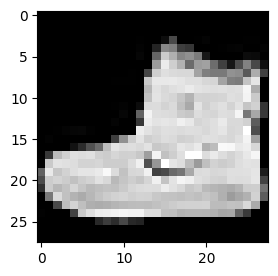

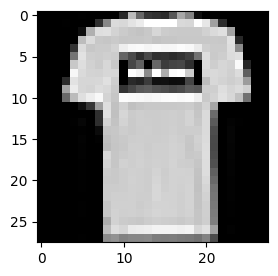

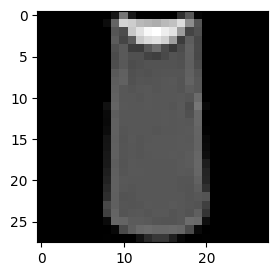

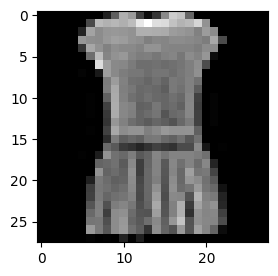

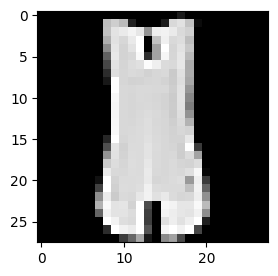

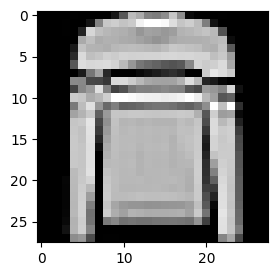

In [11]:
visualize_images(images)

In [12]:
# FROM DOCUMENTATION OF FashionMNIST
label_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [13]:
# Counting the frequency of classes
from collections import Counter
labels = [label for _, label in train_data]
count = Counter(labels)
count

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

**STEP 2 - TRANSFORMATION OF DATA**

In [14]:
all_pixels = torch.stack([pix for pix, _ in train_data])
all_pixels.shape

torch.Size([60000, 1, 28, 28])

In [15]:
# MEAN AND SD OF DATA FOR TRANSFORMATION
data_mean = torch.mean(all_pixels)
data_standard_deviation = torch.std(all_pixels)
print(f"Mean: {data_mean:.2f} and SD: {data_standard_deviation:.2f}")

Mean: 0.29 and SD: 0.35


In [16]:
# Transformation
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((data_mean),(data_standard_deviation))
])

In [17]:
# train data & test data with transformation
transformed_train_data = datasets.FashionMNIST(
    root='/transformed_data',
    train=True,
    transform=transformation,
    download=True
)
transformed_test_data = datasets.FashionMNIST(
    root="/transformed_data",
    train=False,
    transform=transformation,
    download=True
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.8MB/s]


In [18]:
transformed_train_data, transformed_test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: /transformed_data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=0.2860405743122101, std=0.3530242443084717)
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: /transformed_data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=0.2860405743122101, std=0.3530242443084717)
            ))

In [19]:
from torch.utils.data import DataLoader, random_split

In [20]:
train_len = int(0.9 * len(transformed_train_data))
val_len = len(transformed_train_data) - train_len
len(transformed_train_data), train_len, val_len

(60000, 54000, 6000)

In [21]:
train_subset, val_subset = random_split(transformed_train_data, [train_len, val_len])

In [22]:
# Data batches using DataLoader
train_batch = DataLoader(
    dataset=train_subset,
    batch_size=64,
    shuffle=True
)

val_batch = DataLoader(
    dataset=val_subset,
    batch_size=64,
    shuffle=False
)

test_batch = DataLoader(
    dataset=transformed_test_data,
    batch_size=64,
    shuffle=False
)

In [23]:
img, lbls = next(iter(train_batch))
print(f"Shape: {img.shape}")
print(f"Min Value: {img.min().item()}")
print(f"Max Value: {img.max().item()}")

Shape: torch.Size([64, 1, 28, 28])
Min Value: -0.810257613658905
Max Value: 2.022409200668335


**MODEL ARCHITECTURE**

In [24]:
from torch import nn

In [25]:
class FashionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.hidden_layer1 = nn.Linear(in_features=784,out_features=512)
    self.relu1 = nn.ReLU()
    self.hidden_layer2 = nn.Linear(in_features=512, out_features=256)
    self.relu2 = nn.ReLU()
    self.output_layer = nn.Linear(in_features=256, out_features=10)

  def forward(self, x):
    x = self.flatten(x)
    x = self.relu1(self.hidden_layer1(x))
    x = self.relu2(self.hidden_layer2(x))
    return self.output_layer(x)


In [26]:
model = FashionModel().to(device)

In [27]:
# Setting up loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)

In [28]:
def accuracy_fn(y_pred, y_target):
  y_pred = torch.argmax(y_pred, dim=1)
  result = y_pred == y_target
  return result.float().mean()

In [29]:
EPOCH = 20
train_accuracy, train_loss = 0, 0
loss_list_train, loss_list_val = [],[]
accuracy_list_train, accuracy_list_val = [], []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

In [30]:
def validate_model(model, val_batch, device):
  model.eval()
  val_accuracy, val_loss = 0, 0
  with torch.inference_mode():
    for X, y in val_batch:
      X = X.to(device)
      y = y.to(device)

      y_val_pred = model(X)
      loss = loss_fn(y_val_pred, y)

      val_accuracy += accuracy_fn(y_val_pred, y).item()
      val_loss += loss.item()
    val_accuracy /= len(val_batch)
    val_loss /= len(val_batch)
  return val_loss, val_accuracy

In [31]:
import os
Model_dir = "./model"
os.makedirs(Model_dir, exist_ok=True)

In [32]:
for epoch in range(EPOCH):
  model.train()
  train_accuracy, train_loss = 0, 0
  for img_batch, label_batch in train_batch:
    img_batch = img_batch.to(device)
    label_batch = label_batch.to(device)

    y_pred = model(img_batch)
    loss = loss_fn(y_pred, label_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_accuracy += accuracy_fn(y_pred, label_batch).item()
    train_loss += loss.item()

  train_accuracy /= len(train_batch)
  train_loss /= len(train_batch)
  loss_list_train.append(train_loss)
  accuracy_list_train.append(train_accuracy)

  # VALIDATION
  val_loss, val_accuracy = validate_model(model, val_batch, device)
  loss_list_val.append(val_loss)
  accuracy_list_val.append(val_accuracy)

  print(f'''Epoch:{epoch} | Train Loss:{train_loss:.2f} | Train Accuracy:{train_accuracy:.2f}
  | Val Loss:{val_loss:.2f} | Val Accuracy:{val_accuracy:.2f}''')

  if val_loss < best_val_loss:
    patience_counter = 0
    best_val_loss = val_loss
    torch.save(model.state_dict(), f'{Model_dir}/fashion_model.pth')
  else:
    patience_counter += 1

  if patience_counter >= patience:
    print("Best state of the model has been achieved. Early Stopping")
    break



Epoch:0 | Train Loss:0.52 | Train Accuracy:0.81
  | Val Loss:0.38 | Val Accuracy:0.86
Epoch:1 | Train Loss:0.36 | Train Accuracy:0.87
  | Val Loss:0.35 | Val Accuracy:0.87
Epoch:2 | Train Loss:0.32 | Train Accuracy:0.88
  | Val Loss:0.33 | Val Accuracy:0.88
Epoch:3 | Train Loss:0.29 | Train Accuracy:0.89
  | Val Loss:0.35 | Val Accuracy:0.87
Epoch:4 | Train Loss:0.27 | Train Accuracy:0.90
  | Val Loss:0.30 | Val Accuracy:0.89
Epoch:5 | Train Loss:0.25 | Train Accuracy:0.91
  | Val Loss:0.32 | Val Accuracy:0.89
Epoch:6 | Train Loss:0.23 | Train Accuracy:0.91
  | Val Loss:0.32 | Val Accuracy:0.89
Epoch:7 | Train Loss:0.22 | Train Accuracy:0.92
  | Val Loss:0.31 | Val Accuracy:0.89
Best state of the model has been achieved. Early Stopping


**MODEL TESTING**

In [33]:
fashion_model = FashionModel()
state_dict = torch.load(f'{Model_dir}/fashion_model.pth')
fashion_model.load_state_dict(state_dict)
fashion_model = fashion_model.to(device)

In [34]:
test_loss, test_accuracy = 0, 0
for img, label in test_batch:
  img, label = img.to(device), label.to(device)
  fashion_model.eval()
  y_pred = fashion_model(img)
  loss = loss_fn(y_pred, label)
  test_accuracy += accuracy_fn(y_pred, label)
  test_loss += loss.item()

test_accuracy /= len(test_batch)
test_loss /= len(test_batch)
print(f"Test Accuracy: {test_accuracy:.2f} | Test Loss: {test_loss:.2f}")


Test Accuracy: 0.88 | Test Loss: 0.32


**VISUALIZATION**

In [35]:
import os
os.makedirs("plots", exist_ok=True)

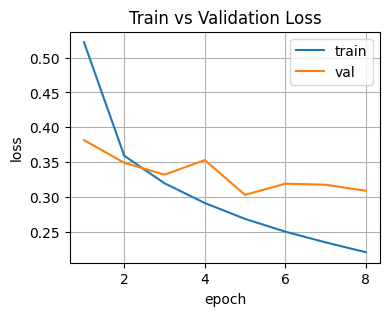

In [36]:
epoch = range(1, len(loss_list_train)+1)

plt.figure(figsize=(4,3))
plt.plot(epoch, loss_list_train, label="train")
plt.plot(epoch, loss_list_val, label="val")

plt.title("Train vs Validation Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)

plt.savefig("plots/loss_curve.png", dpi=300)
plt.show()

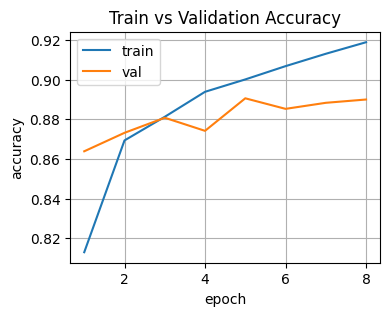

In [39]:
plt.figure(figsize=(4,3))
plt.plot(epoch, accuracy_list_train, label="train")
plt.plot(epoch, accuracy_list_val, label="val")

plt.title("Train vs Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True)
plt.savefig("plots/accuracy_curve.png", dpi=300)
plt.show()

In [38]:
!python --version

Python 3.12.12
